In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pygeohash as pgh
import geohash2 as gh2
import lxml.etree as etree
import re
import seaborn as sns
from scipy import stats

## Read file 


In [5]:
file_path = '1987-2016.kml'
# read file
ty_name=[]
intensity=[]
mslp=[]
max_int=[]
min_slp=[]
timesteps=[]
lon=[]
lat=[]
ty_data=np.ndarray(shape = (0,1))
z = np.zeros((0,1))
parser = etree.XMLParser(strip_cdata=False)
tree = etree.parse(file_path, parser=parser)
#print(etree.tostring(tree, xml_declaration=True))
#print(tree.xpath('//kml:Placemark/kml:TimeSpan/text()', namespaces={"kml":"http://www.opengis.net/kml/2.2"}))
nmsp = '{http://www.opengis.net/kml/2.2}'


## Data Cleansing & Data Preparation

In [6]:
### walk through history typhoon file ###
for fd in tree.iterfind('/{0}Document/{0}Folder/{0}Folder/{0}Folder'.format(nmsp)):
    temp = fd.find('{0}Placemark/{0}name'.format(nmsp)).text
    ty_name.append(temp)
    count=0
    ## feature extraction ##
    for dscp in fd.iterfind('{0}Placemark'.format(nmsp)):
        #print(dscp.find('{0}description'.format(nmsp)).text)
        dscript = dscp.find('{0}description'.format(nmsp)).text
        dscript = re.split(r'<[^>]+>|[\s\n\t]', dscript)
        temp_info= np.array([ele for ele in dscript if len(ele)>0])
        #print(len(temp_info))
        if len(temp_info) == 26:
            temp_info=np.append(temp_info,count)
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[13]])
            mslp=np.append(mslp,[temp_info[16]])
            max_int=np.append(max_int,[temp_info[20]])
            min_slp=np.append(min_slp,[temp_info[24]])
            count+=1
        elif len(temp_info) == 30:
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[17]])
            mslp=np.append(mslp,[temp_info[20]])
            max_int=np.append(max_int,[temp_info[24]])
            min_slp=np.append(min_slp,[temp_info[28]])
            count+=1
        elif len(temp_info) == 33:
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[17]])
            mslp=np.append(mslp,[temp_info[23]])
            max_int=np.append(max_int,[temp_info[27]])
            min_slp=np.append(min_slp,[temp_info[31]])
            count+=1
        elif len(temp_info) == 35:
            timesteps=np.append(timesteps,count)
            intensity=np.append(intensity,[temp_info[20]])
            mslp=np.append(mslp,[temp_info[25]])
            max_int=np.append(max_int,[temp_info[29]])
            min_slp=np.append(min_slp,[temp_info[33]])
            count+=1
    for i in range(count,105):
        timesteps=np.append(timesteps,[i], axis=0)
        intensity= np.append(intensity, [0], axis = 0)
        mslp= np.append(mslp, [0], axis = 0)
        max_int= np.append(max_int, [0], axis = 0)
        min_slp= np.append(min_slp, [0], axis = 0)
        count+=1
    

In [7]:
### Geogaphic coordinate feature extraction ###
lon=[]
lat=[]
for fd in tree.iterfind('/{0}Document/{0}Folder/{0}Folder/{0}Folder'.format(nmsp)):
    count=0
    for coor in fd.iterfind('{0}Placemark/{0}Point'.format(nmsp)):
        geocoor = coor.find('{0}coordinates'.format(nmsp)).text
        lontitude,latitude,_ = geocoor.split(',')
        lon = np.append(lon,lontitude)
        lat = np.append(lat,latitude)
        count+=1
    for i in range(count,105):
        lon = np.append(lon,lon[-1])
        lat = np.append(lat,lat[-1])
    #print(len(lon))


In [8]:
lon = np.asanyarray(lon, dtype=np.float)
lat = np.asanyarray(lat, dtype=np.float)
intensity = np.asanyarray(intensity, dtype=np.float)
mslp = np.asanyarray(mslp, dtype=np.float)
max_int = np.asanyarray(max_int, dtype=np.float)
min_slp = np.asanyarray(min_slp, dtype=np.float)

for i in range(len(lon)):
    if lon[i] < 0:
        lon[i] = lon[i]+360
for i in range(len(mslp)):
    if mslp[i] == 9999:
        mslp[i] = mslp[np.where((mslp!=9999)|(mslp!=0))].mean()

lon_train, lon_test = lon[:71505], lon[-23835:]
lat_train, lat_test = lat[:71505], lat[-23835:]
intensity_train, intensity_test = intensity[:71505], intensity[-23835:]
mslp_train, mslp_test = mslp[:71505], mslp[-23835:]
max_int_train, max_int_test = max_int[:71505], max_int[-23835:]
min_slp_train, min_slp_test = min_slp[0:71505], min_slp[-23835:]

In [37]:
#  Dataframe for training
data_train = {'lon':lon_train,'lat':lat_train,'Intensity':intensity_train}
data_test = {'lon':lon_test,'lat':lat_test,'Intensity':intensity_test}
X_train = pd.DataFrame(data=data_train)
X_test = pd.DataFrame(data=data_test)
# target Dataframe
y_train = X_train.shift(1)
y_train = pd.DataFrame(data=y_train)
y_train.fillna(0, inplace=True)
y_test = X_test.shift(1)
y_test = pd.DataFrame(data=y_test)
y_test.fillna(0, inplace=True)

In [339]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
inverted_X = scaler.inverse_transform(scaled_X_train)

scaled_X_test = scaler.transform(X_test)
inverted_X_test = scaler.transform(scaled_X_test)

scaled_y_train = scaler.transform(y_train)
inverted_y = scaler.inverse_transform(scaled_y_train)

scaled_y_test = scaler.transform(y_test)
inverted_y_test = scaler.transform(scaled_y_test)

## Data Distribution

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


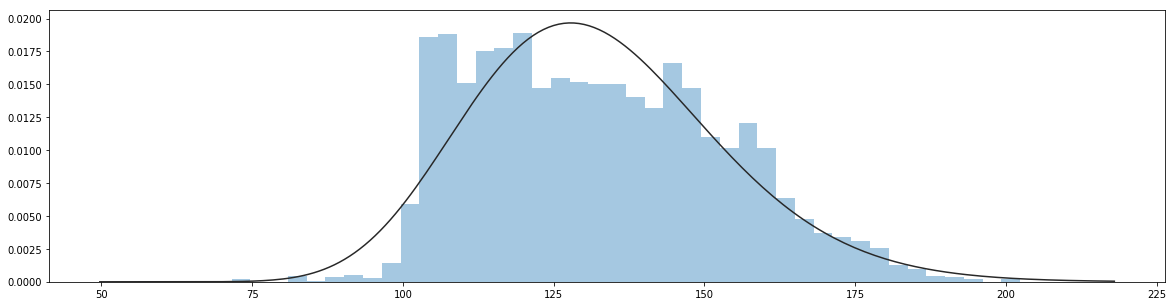

In [266]:
plt.figure(figsize=(20,5))
sns.distplot(lon, kde=False, fit=stats.gamma, hist=True)

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


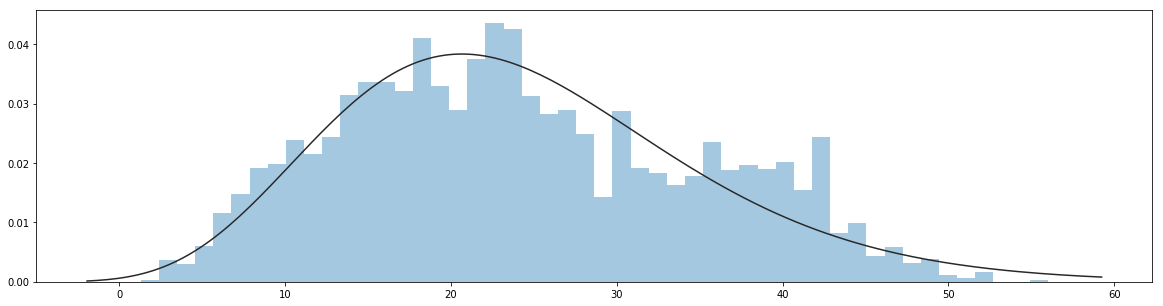

In [200]:

plt.figure(figsize=(20,5))
sns.distplot(lat, kde=False, fit=stats.gamma, hist=True)

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


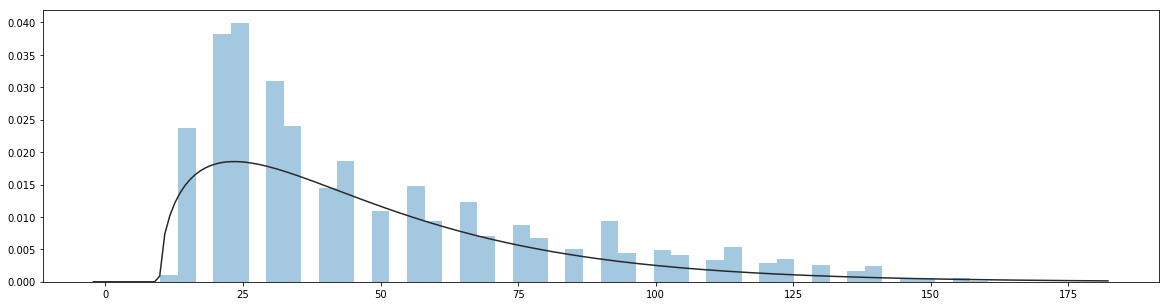

In [293]:
plt.figure(figsize=(20,5))
sns.distplot(intensity[intensity!=0], kde=False, fit=stats.gamma, hist=True)

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


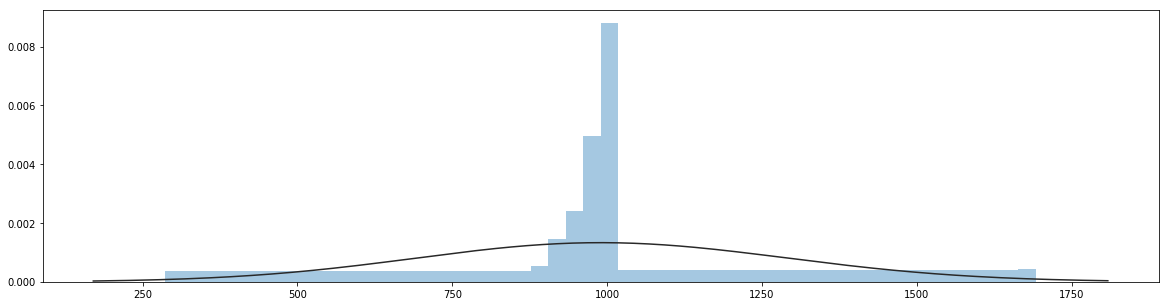

In [290]:
plt.figure(figsize=(20,5))
sns.distplot(mslp[mslp!=0], kde=False, fit=stats.gamma, hist=True)

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


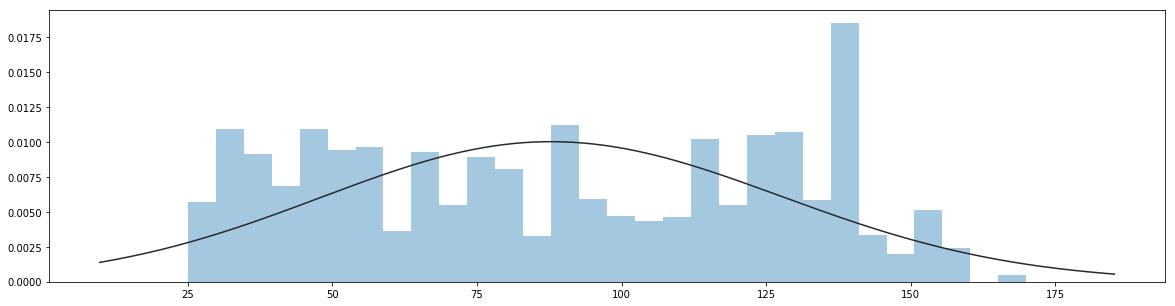

In [289]:
plt.figure(figsize=(20,5))
sns.distplot(max_int[max_int!=0], kde=False, fit=stats.gamma, hist=True)

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


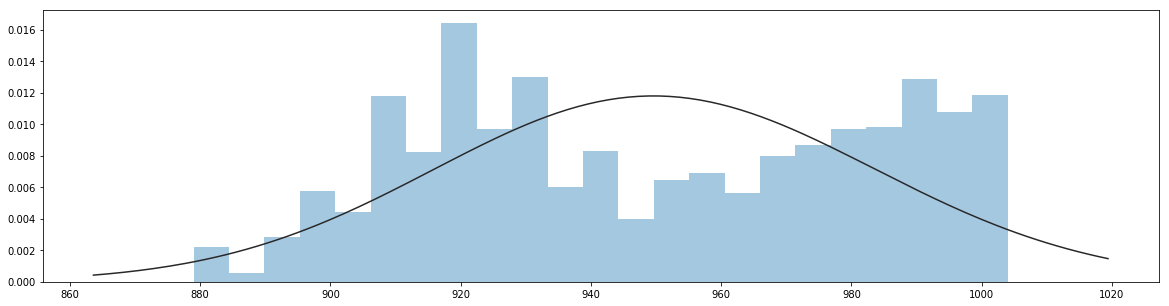

In [288]:
plt.figure(figsize=(20,5))
sns.distplot(min_slp[min_slp!=0], kde=False, fit=stats.gamma, hist=True)

In [128]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


## Build Model

In [340]:
def fit_lstm(train, target, batch_size, nb_epoch, neurons):
    X, y = train[:,:], target[:,:]
    X = train.reshape(train.shape[0], 1, train.shape[1])
    
    
    RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9, decay=0.0, clipvalue=0.1)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(3))
    model.compile(loss='mse', optimizer=RMSprop, metrics=['acc'])
    es = EarlyStopping(monitor='val_loss', patience=5)
    for i in range(0, X.shape[0], 105):
        model.fit(X, y, epochs=1000, batch_size=batch_size, verbose=1, shuffle=False,validation_split=0.2,callbacks=[es])
        model.reset_states()
    model.save('lstm_RMSprop.h5')
    
    return model


In [341]:
fit_lstm(scaled_X_train, scaled_y_train, 1, 1000, 128)

Train on 57204 samples, validate on 14301 samples
Epoch 1/1
57204/57204 [==============================] - 136s 2ms/step - loss: 0.5752 - acc: 0.5948 - val_loss: 0.6044 - val_acc: 0.5897
Train on 57204 samples, validate on 14301 samples
Epoch 1/1
57204/57204 [==============================] - 140s 2ms/step - loss: 0.5632 - acc: 0.6163 - val_loss: 0.6014 - val_acc: 0.5806
Train on 57204 samples, validate on 14301 samples
Epoch 1/1
57204/57204 [==============================] - 130s 2ms/step - loss: 0.5643 - acc: 0.6146 - val_loss: 0.6029 - val_acc: 0.5713
Train on 57204 samples, validate on 14301 samples
Epoch 1/1
57204/57204 [==============================] - 129s 2ms/step - loss: 0.5641 - acc: 0.6148 - val_loss: 0.6021 - val_acc: 0.5724
Train on 57204 samples, validate on 14301 samples
Epoch 1/1
57204/57204 [==============================] - 141s 2ms/step - loss: 0.5633 - acc: 0.6147 - val_loss: 0.6002 - val_acc: 0.5737
Train on 57204 samples, validate on 14301 samples
Epoch 1/1
57204

KeyboardInterrupt: 

In [124]:
model = load_model('lstm_RMSprop.h5')
train_reshaped = scaled_X.reshape(1800, 1, 11)
a = model.predict(train_reshaped, batch_size=1)
inversed_X = scaler.inverse_transform(a)

NameError: name 'load_model' is not defined